## Test Configuration
| Duct Configuration  | Propeller Type       | Measured Propeller Diameter | Propeller Tip Profile | Duct Inner Diameter | Lip Configuration |
| --------------------|----------------------|-----------------------------|-----------------------|---------------------| ------------------|
| Open air / unducted | HQ Prop 5" Hex Blade |                             | Original / Unshaved   | N/A                 | None              |

## Procedure
Initiate throttle sweep from 0-100% throttle in increments of 5%, holding each step for 5 seconds. For each aerodynamic configuration, disassemble and reassemble between tests to ensure repeatability.

## Hypothesis
We expect the low blade count and low pitch propellers to be more power efficient, but produce less thrust.

## Impact
The results from this test will determine the props used in the rest of our testing. Props that produce significantly less thrust than required to lift a payload (~12 N) will be eliminated and a propeller with high power efficiency around the 12 N range will be selected, with slight preference toward high efficiency in the 8 N range (flight without payload) and high full throttle thrust.

This test will also validate full throttle performance of our motors. Another possible outcome of this test is that the low-KV motors do not spin our propellers fast enough to produce enough thrust for flight with a payload. If so, new motors will need to be purchased and these tests will have to be rerun with those motors, as both motors and propellers contribute to power efficiency.

## Analysis
Average battery voltage, motor currents, and thrust will be collected for each throttle step after the transients stabilize, and a thrust vs. electrical power plot will be made to compare all props.

## Observations

For our first few full throttle tests, we noticed our thrust start to decrease as throttle went above about 75%, the root cause of this was determined to be the movable carriage hitting the end stops, which were taking up some of the load since the jig was remounted to a new base and the relative positioning of components changed since the last test.

In [1]:
from runner import test_run, TestPlan, TestStep
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Specify Test Plan
Initialize a test plan object which sweeps from 0 to 100% throttle in increments of 5%, holding at each step for 2 seconds

In [2]:
# 1. Create a test plan consisting of steps.
step_duration_ms = 2_000
step_range = np.arange(5, 101, 5)
steps = [
    TestStep(bottom_throttle=i, top_throttle=i, duration_ms=step_duration_ms)
    for i in step_range
]
plan = TestPlan("test", steps=steps)
plan

TestPlan(name='test', steps=[TestStep(duration_ms=2000, top_throttle=5, bottom_throttle=5, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=10, bottom_throttle=10, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=15, bottom_throttle=15, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=20, bottom_throttle=20, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=25, bottom_throttle=25, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=30, bottom_throttle=30, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=35, bottom_throttle=35, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=40, bottom_throttle=40, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=45, bottom_throttle=45, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=50, bottom_throttle=50, pitch_ang

### Execute Tests

In [3]:
test_directory = Path("../test_data/open_air/")
data_dict = {}

In [4]:
data_dict["test_5in_6blade"] = test_run(
    filename=test_directory / "test_5in_6blade.csv", plan=plan
)
data_dict["test_5in_4blade_blue"] = test_run(
    filename=test_directory / "test_5in_4blade_blue.csv", plan=plan
)
data_dict["test_6in_4blade"] = test_run(
    filename=test_directory / "test_6in_4blade.csv", plan=plan
)
data_dict["test_7in_3blade"] = test_run(
    filename=test_directory / "test_7in_3blade.csv", plan=plan
)
data_dict["test_5in_toroidal"] = test_run(
    filename=test_directory / "test_5in_toroidal.csv", plan=plan
)

Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data


### Data Analysis

In [5]:
# Aggregate test data
df_all = pd.concat(data_dict, names=["test_name"])
df_all

top_motor_rpm  bottom_motor_rpm  batt_voltage_V  \
test_name         time_ms                                                      
test_5in_6blade   0.446                0.0               0.0       18.018000   
                  5.174                0.0               0.0       17.240999   
                  8.154                0.0               0.0       17.052000   
                  11.162               0.0               0.0       16.926001   
                  14.154               0.0               0.0       16.841999   
...                                    ...               ...             ...   
test_5in_toroidal 41969.155         1157.0            1171.0       16.128000   
                  41972.159         1100.0            1128.0       16.149000   
                  41976.155         1100.0            1100.0       16.170000   
                  41979.159         1028.0            1057.0       16.149000   
                  41982.147         1028.0             957.0       16.191000   

                             batt_current_A  top_current_A  bottom_current_A  \
test_name         time_ms                                                      
test_5in_6blade   0.446               10.24        0.08724          -0.36166   
                  5.174               10.24        0.14540          -0.29211   
                  8.154               10.24        0.08724          -0.25038   
                  11.162              10.24        0.10178          -0.22256   
                  14.154              10.24        0.15994          -0.20865   
...                                     ...            ...               ...   
test_5in_toroidal 41969.155           10.24        0.17448          -0.26429   
                  41972.159           10.24        0.05816          -0.20865   
                  41976.155           10.24        0.18902          -0.29211   
                  41979.159           10.24        0.18902          -0.25038   
                  41982.147           10.24        0.04362          -0.18083   

                             thrust_N  torque_N  
test_name         time_ms                        
test_5in_6blade   0.446     -0.130701 -0.000675  
                  5.174     -0.130701 -0.000675  
                  8.154     -0.130701 -0.000675  
                  11.162    -0.130701 -0.000675  
                  14.154    -0.130701 -0.000675  
...                               ...       ...  
test_5in_toroidal 41969.155  0.886869  0.004453  
                  41972.159  0.886869  0.003343  
                  41976.155  0.886869  0.003343  
                  41979.159  0.886869  0.003343  
                  41982.147  0.886869  0.003343  

[68818 rows x 8 columns]

In [6]:
# Select single test to analyze closer
test_data = df_all.loc["test_5in_6blade"]
test_data

,top_motor_rpm,bottom_motor_rpm,batt_voltage_V,batt_current_A,top_current_A,bottom_current_A,thrust_N,torque_N
time_ms,,,,,,,,
0.446,0.0,0.0,18.018000,10.24,0.08724,-0.36166,-0.130701,-0.000675
5.174,0.0,0.0,17.240999,10.24,0.14540,-0.29211,-0.130701,-0.000675
8.154,0.0,0.0,17.052000,10.24,0.08724,-0.25038,-0.130701,-0.000675
11.162,0.0,0.0,16.926001,10.24,0.10178,-0.22256,-0.130701,-0.000675
14.154,0.0,0.0,16.841999,10.24,0.15994,-0.20865,-0.130701,-0.000675
...,...,...,...,...,...,...,...,...
41969.158,1528.0,1471.0,15.834000,10.24,0.08724,-0.12519,1.714019,0.007230
41972.154,1528.0,1485.0,15.834000,10.24,-0.00000,-0.29211,1.714019,0.007230
41975.158,1457.0,1400.0,15.813000,10.24,0.05816,-0.11128,1.714019,0.007230


In [7]:
# Extract raw data from a loaded test csv
top_current_raw = test_data["top_current_A"]
bottom_current_raw = test_data["bottom_current_A"]
hall_current_raw = top_current_raw + bottom_current_raw

shunt_current_raw = test_data["batt_current_A"]
batt_voltage = test_data["batt_voltage_V"]

top_rpm = test_data["top_motor_rpm"]
bottom_rpm = test_data["bottom_motor_rpm"]

thrust_N = test_data["thrust_N"]
time_ms = test_data.index

# Determine mean sample rate
sample_rate_ms = np.mean(np.diff(time_ms))

In [8]:
# Generate buckets for averaging based on step duration defined in testing
stable_step_duration_ms = step_duration_ms / 2
transient_offset_ms = (
    500  # Ignore first 500 ms of each throttle step to allow transients to settle
)
step_start_times = np.arange(len(step_range)) * step_duration_ms


# Aggregate data for each throttle step
df_steps = (
    pd.concat(
        [
            df_all.loc[
                (
                    slice(None),
                    slice(
                        t_start + transient_offset_ms,
                        t_start + transient_offset_ms + stable_step_duration_ms,
                    ),
                ),
                :,
            ]
            for t_start in step_start_times
        ],
        keys=step_range,
        names=["throttle"],
    )
    .groupby(["test_name", "throttle"])
    .mean()
)

df_steps

top_motor_rpm  bottom_motor_rpm  \
test_name            throttle                                    
test_5in_4blade_blue 5           1792.368098       1777.834356   
                     10          3235.898773       3197.730061   
                     15          4595.696319       4544.791411   
                     20          5700.067485       5858.457055   
                     25          7313.604294       7132.134969   
...                                      ...               ...   
test_7in_3blade      80         15456.418182      15290.845455   
                     85         16073.498480      15802.796353   
                     90         16562.343465      16239.513678   
                     95         16962.110429      16683.763804   
                     100        17327.685015      17116.819572   

                               batt_voltage_V  batt_current_A  top_current_A  \
test_name            throttle                                                  
test_5in_4blade_blue 5              16.803284       10.240000       0.291291   
                     10             16.796714       10.240000       0.406183   
                     15             16.774490       10.240000       0.527722   
                     20             16.754263       10.240000       0.679678   
                     25             16.719350       10.240000       0.885156   
...                                       ...             ...            ...   
test_7in_3blade      80             14.876464       43.011878      19.269201   
                     85             14.607128       48.749423      22.055589   
                     90             14.330489       53.895684      25.089013   
                     95             14.078954       59.605399      28.035439   
                     100            13.825450       64.425443      30.404563   

                               bottom_current_A   thrust_N  torque_N  
test_name            throttle                                         
test_5in_4blade_blue 5                -0.113456   0.000268  0.000403  
                     10               -0.027180  -0.000806  0.000635  
                     15                0.081881  -0.001881  0.001267  
                     20                0.153223  -0.001038  0.001349  
                     25                0.251191   0.001023  0.002399  
...                                         ...        ...       ...  
test_7in_3blade      80               16.815588  16.054723  0.089379  
                     85               19.417853  17.040247  0.092119  
                     90               22.070688  17.986697  0.099434  
                     95               24.837542  17.531845  0.108973  
                     100              27.773165  16.799926  0.110301  

[100 rows x 8 columns]

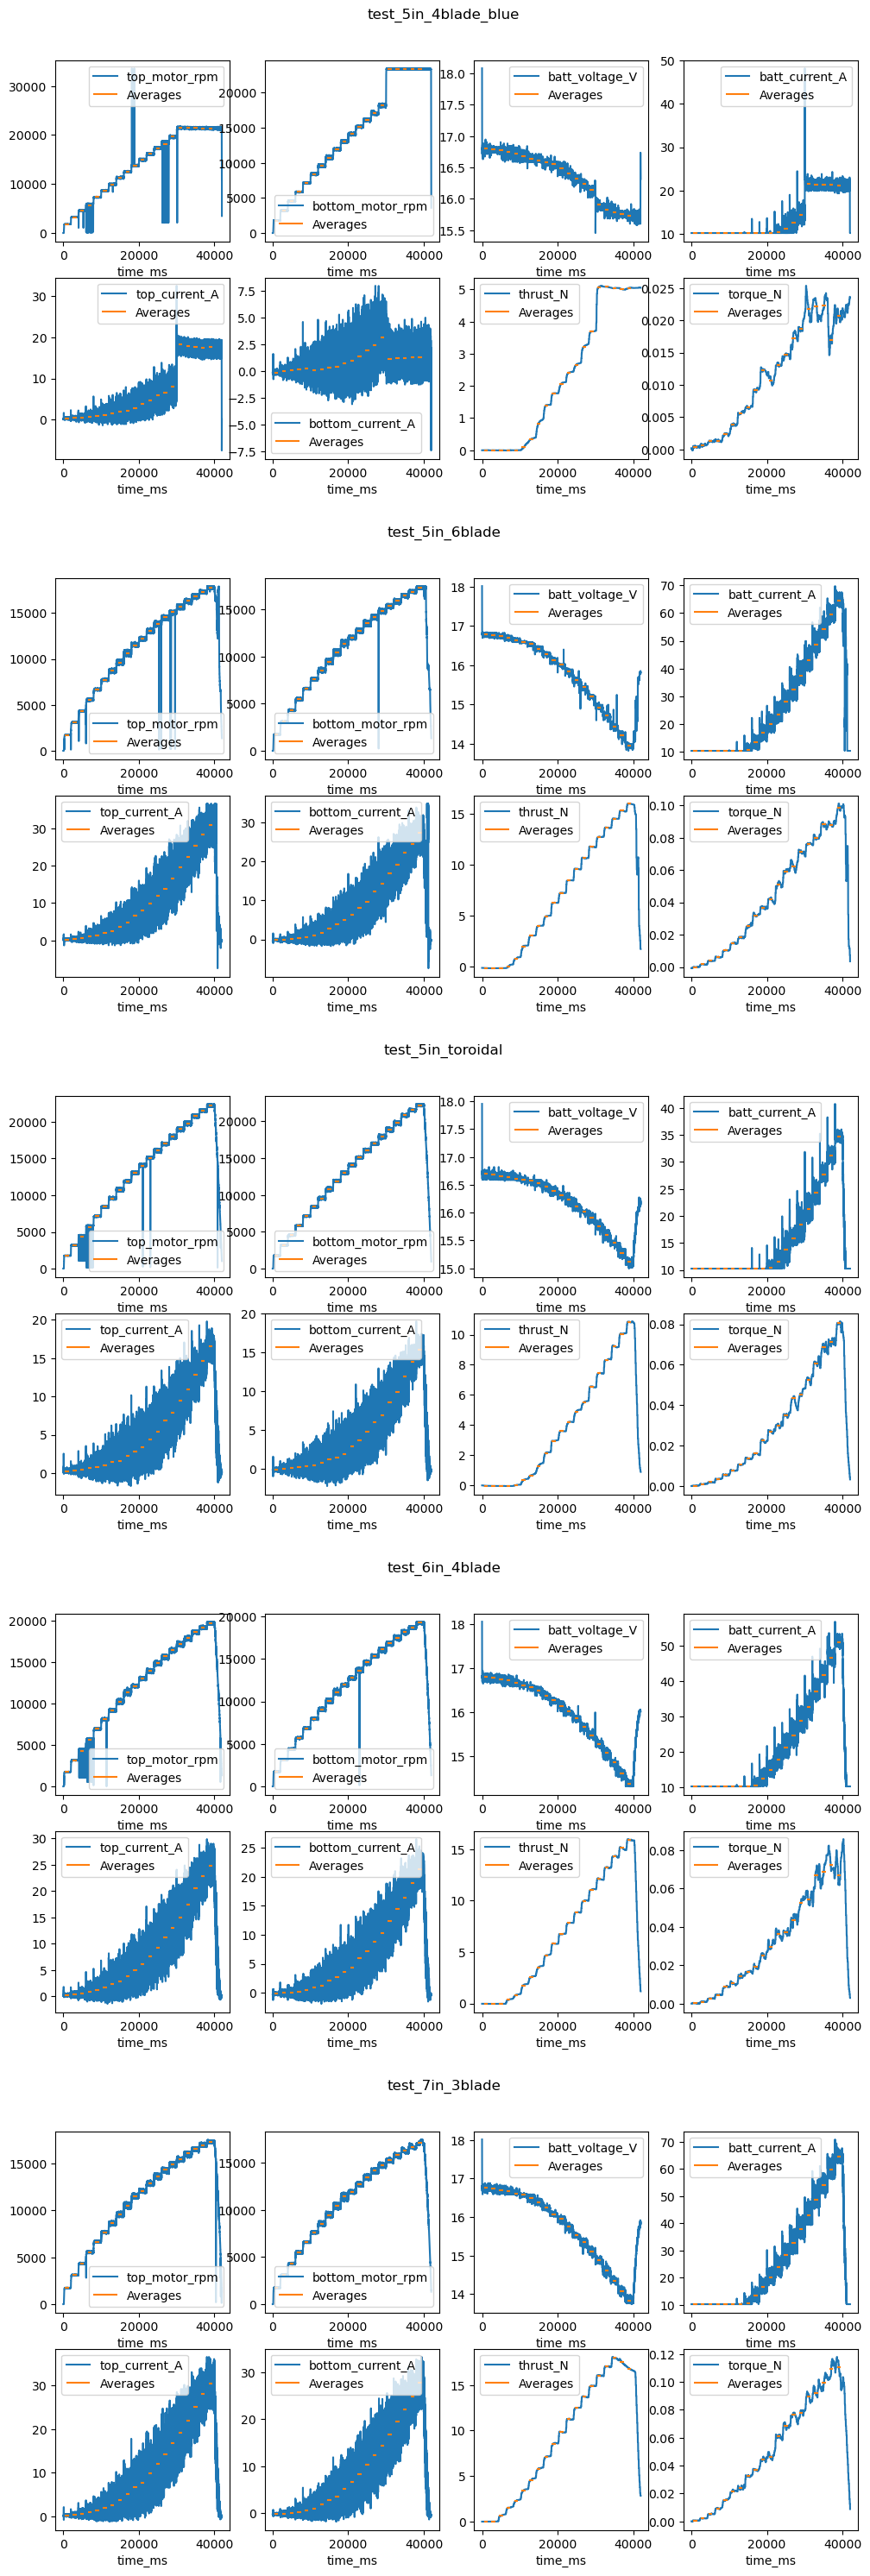

In [9]:
# Debug plots
fig = plt.figure(figsize=(12, 6*len(data_dict)))
subfigs = fig.subfigures(len(data_dict), 1)
if not isinstance(subfigs, np.ndarray):
    subfigs = np.array([subfigs])
for subfig, (n, grp) in zip(subfigs, df_all.groupby("test_name")):
    axs = subfig.subplots(2, 4)
    for ax, col in zip(axs.flat, grp):
        grp.reset_index("test_name").plot(ax=ax, y=col)
        ax.hlines(
            df_steps[col].loc[n],
            step_start_times + transient_offset_ms,
            step_start_times + transient_offset_ms + stable_step_duration_ms,
            colors="C1",
            label="Averages",
        )
        ax.legend()
    subfig.suptitle(n)

In [10]:
thrust_mean_g = df_steps["thrust_N"] / 9.81 * 1e3
thrust_mean_g = thrust_mean_g * (thrust_mean_g > 0)
hover_thrust_g = 750
payload_thrust_g = 1200

hall_current_mean = df_steps["top_current_A"] + df_steps["bottom_current_A"]
batt_voltage_mean = df_steps["batt_voltage_V"]
batt_power_mean = hall_current_mean * batt_voltage_mean

df_thrust_power = pd.DataFrame(
    {
        "thrust_mean_g": thrust_mean_g,
        "batt_power_mean": batt_power_mean,
        "thrust_power_g_W": thrust_mean_g / batt_power_mean,
    }
)
df_thrust_power

thrust_mean_g  batt_power_mean  \
test_name            throttle                                   
test_5in_4blade_blue 5              0.027315         2.988204   
                     10            -0.000000         6.366012   
                     15            -0.000000        10.225779   
                     20            -0.000000        13.954650   
                     25             0.104285        18.998977   
...                                      ...              ...   
test_7in_3blade      80          1636.567099       536.814057   
                     85          1737.028203       605.807856   
                     90          1833.506347       675.821599   
                     95          1787.140202       744.396276   
                     100         1712.530677       804.333249   

                               thrust_power_g_W  
test_name            throttle                    
test_5in_4blade_blue 5                 0.009141  
                     10               -0.000000  
                     15               -0.000000  
                     20               -0.000000  
                     25                0.005489  
...                                         ...  
test_7in_3blade      80                3.048667  
                     85                2.867292  
                     90                2.713003  
                     95                2.400791  
                     100               2.129131  

[100 rows x 3 columns]

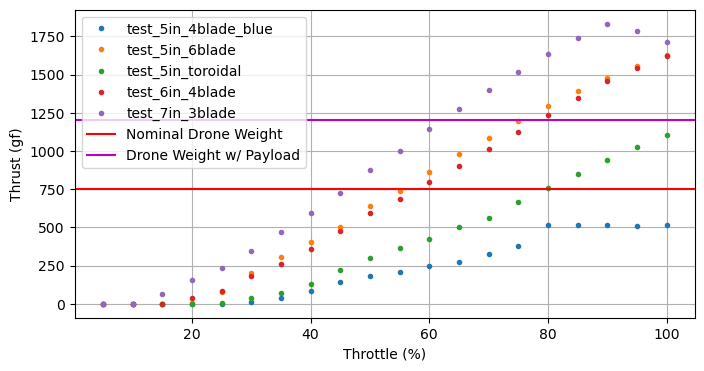

In [11]:
thrust_mean_g.unstack("test_name").plot(style=".", figsize=(8, 4))
plt.xlabel("Throttle (%)")
plt.ylabel("Thrust (gf)")
plt.axhline(hover_thrust_g, color="r", label="Nominal Drone Weight")
plt.axhline(payload_thrust_g, color="m", label="Drone Weight w/ Payload")
plt.legend()
plt.grid()
plt.show()

In [12]:
# TODO: nominal thrust-weight ratio plot
# thrust_mean_g.iloc[-1] / hover_thrust_g

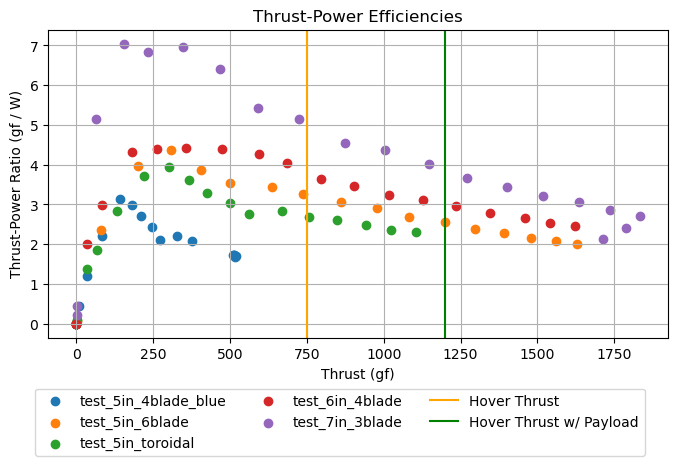

In [13]:
fig = plt.figure(figsize=(8, 4))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x="thrust_mean_g", y="thrust_power_g_W", data=grp, label=n)
plt.xlabel("Thrust (gf)")
plt.ylabel("Thrust-Power Ratio (gf / W)")
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.grid()
plt.legend(ncols=3, bbox_transform=fig.transFigure, bbox_to_anchor=(0.1, 0), loc="upper left")
plt.title("Thrust-Power Efficiencies")
plt.show()

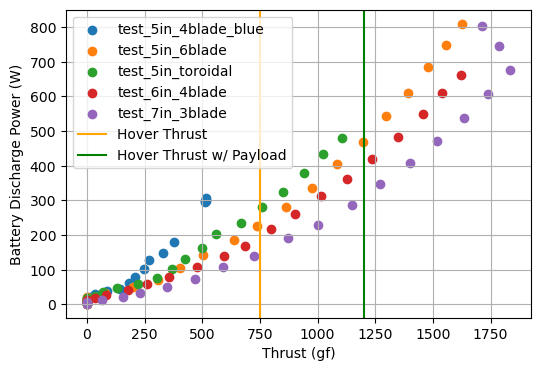

In [14]:
plt.figure(figsize=(6, 4))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x="thrust_mean_g", y="batt_power_mean", data=grp, label=n)
plt.grid()
plt.xlabel("Thrust (gf)")
plt.ylabel("Battery Discharge Power (W)")
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.legend()
plt.show()

In [15]:
characteristic_thrust = pd.Index(
    [hover_thrust_g, payload_thrust_g], name="thrust_mean_g"
)
# Interpolate power at hover and payload thrust
df_power_interp = (
    df_thrust_power.reset_index("throttle")
    .set_index("thrust_mean_g", append=True)
    .groupby("test_name")
    .apply(
        lambda g: (gd := g.droplevel("test_name").dropna())[
            ~gd.index.duplicated(keep="first")
        ]
        .reindex(gd.index.append(characteristic_thrust).unique())
        .sort_index()
        .interpolate(method="index", limit_area="inside")
        .loc[characteristic_thrust]
    )
)
df_power_interp

throttle  batt_power_mean  \
test_name            thrust_mean_g                               
test_5in_4blade_blue 750.0                NaN              NaN   
                     1200.0               NaN              NaN   
test_5in_6blade      750.0          55.555152       232.594791   
                     1200.0         75.104333       470.201963   
test_5in_toroidal    750.0          79.533246       277.476235   
                     1200.0               NaN              NaN   
test_6in_4blade      750.0          57.893512       197.913074   
                     1200.0         78.403050       400.279195   
test_7in_3blade      750.0          45.839961       149.335489   
                     1200.0         62.109956       311.979049   

                                    thrust_power_g_W  
test_name            thrust_mean_g                    
test_5in_4blade_blue 750.0                       NaN  
                     1200.0                      NaN  
test_5in_6blade      750.0                  3.229140  
                     1200.0                 2.552638  
test_5in_toroidal    750.0                  2.705124  
                     1200.0                      NaN  
test_6in_4blade      750.0                  3.812561  
                     1200.0                 3.003080  
test_7in_3blade      750.0                  5.050823  
                     1200.0                 3.863594

In [16]:
battery_capacity_Wh = 2 * 0.650 * 14.8
flight_time = pd.to_timedelta(
    battery_capacity_Wh / df_power_interp["batt_power_mean"], unit="h"
).rename("flight_time")
flight_time

test_name             thrust_mean_g
test_5in_4blade_blue  750.0                                 NaT
                      1200.0                                NaT
test_5in_6blade       750.0           0 days 00:04:57.788267750
                      1200.0          0 days 00:02:27.306913639
test_5in_toroidal     750.0           0 days 00:04:09.621377778
                      1200.0                                NaT
test_6in_4blade       750.0           0 days 00:05:49.971826096
                      1200.0          0 days 00:02:53.039220979
test_7in_3blade       750.0           0 days 00:07:43.814732919
                      1200.0          0 days 00:03:42.014908288
Name: flight_time, dtype: timedelta64[ns]

<Axes: title={'center': 'Flight time with a 4S 1300mAh battery pack'}, xlabel='Thrust (gf)', ylabel='Flight time (minutes)'>

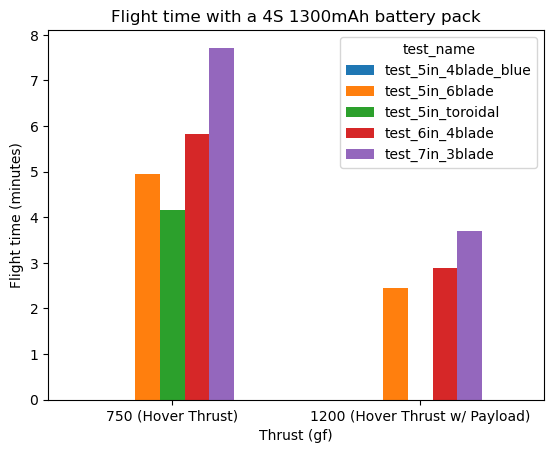

In [17]:
(
    flight_time.dt.seconds.unstack("test_name").rename(
        index={
            hover_thrust_g: f"{hover_thrust_g} (Hover Thrust)",
            payload_thrust_g: f"{payload_thrust_g} (Hover Thrust w/ Payload)",
        }
    )
    / 60
).plot.bar(
    title="Flight time with a 4S 1300mAh battery pack",
    xlabel="Thrust (gf)",
    ylabel="Flight time (minutes)",
    rot=0,
)